In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

##  Функции для статистических тестов

In [2]:
# Функция для визуализации распределения и характера наблюдений

def qqbox(test, control):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    sns.boxplot(x=test, ax=axes[0, 0], palette='BuPu_r')
    axes[0, 0].set_title('Наблюдения в тестовой группе')
    sns.boxplot(x=control, ax=axes[0, 1], palette='BuPu_r')
    axes[0, 1].set_title('Наблюдения в контрольной группе')

    pg.qqplot(test, ax=axes[1, 0])
    axes[1, 0].set_title('Распределение тестовой группы')
    pg.qqplot(control, ax=axes[1, 1])
    axes[1, 1].set_title('Распределение в контрольной группе')

    plt.tight_layout()
    plt.show()

In [3]:
# Тест Шапиро-Уилка на нормальность распределения

def normality(test, control):
    # check normality
    statisctic, p_test = stats.shapiro(test)
    statisctic, p_control = stats.shapiro(control)
    
    if p_test < 0.05 and p_control < 0.05:
        print('Распределение в обеих группах не принадлежит к нормальному')
    elif p_test > 0.05 and p_control < 0.05:
        print('Распределение в тестовой группе принадлежит к нормальному')
    elif p_test < 0.05 and p_control > 0.05:
        print('Распределение в контрольной группе принадлежит к нормальному')
    else:
        print('Распределение в обеих группах принадлежит к нормальному')
        
    print(f'p_value тестовой группы = {p_test}',
          f"p_value контрольной группы = {p_control}", sep='\n')

In [4]:
# T-test func

def t_test(test, control):
    
    # Визуализируем распределения
    plt.figure(figsize=(10, 8))
    sns.distplot(test)
    sns.distplot(control)
    plt.title('Распределения тестовой и контрольной групп')
    plt.legend(['Тестовая группа', 'Контрольная группа'])
    plt.show()

    
    # Количество наблюдений в каждой из групп
    print(f'Наблюдений в тестовой группе: {test.shape[0]}',
          f'Наблюдений в контрольной группе: {control.shape[0]}', sep='\n')
    
    # Проверяем гомогенность дисперсий
    statistic, pvalue_var = stats.levene(test, control)
    
    if pvalue_var > 0.05:
        print('Дисперсии гомогенны')
        # Т-тест с гомогенными дисперсиями
        statistic, pvalue = stats.ttest_ind(test, control)
    else:
        print('Дисперсии гетерогенны')
        # Т-тест с параметром equal_var=False
        statistic, pvalue = stats.ttest_ind(test, control, equal_var=False)
        
        
    # Выводим результаты теста
    print('Результаты теста:')
    print(f"Статистика: {statistic}")
    print(f"p-value: {pvalue}")
    
    if pvalue > 0.05:
        print("H0: A==B - Группы не различаются!")
    else:
        print("H1: A!=B -  Группы статистически значимо различаются!")

In [5]:
# Bootstrap-функция

def bootstrap(test, control):
    from tqdm import tqdm
    boot_len = max([len(test), len(control)])
    means = []
    
    for _ in tqdm(range(10000)):
        sample_test = test.sample(boot_len, replace=True).values
        sample_control = control.sample(boot_len, replace=True).values
        means.append(np.mean(sample_test - sample_control))
        
        df_means = pd.DataFrame(means)
        
        # Находим доверительный интервал  
        borders = np.percentile(df_means, [2.5, 97.5])
    
    # Визуализируем результат
    sns.distplot(df_means)
    plt.title('Распределение разниц средних')
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.vlines(0, ymin=0, ymax=0.003, linestyles='--', colors='red')  
    plt.vlines(borders, ymin=0, ymax=0.003, linestyles='--', colors='grey')
    plt.show()
    
    return print(f"Доверительный интервал: {borders}")

## Посмотрим на данные

In [6]:
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ki-k/STATS/datasets/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ki-k/STATS/datasets/ab_products.csv')
user_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ki-k/STATS/datasets/ab_users_data.csv')

In [7]:
users_order = pd.merge(user_data, orders, on='order_id')

In [8]:
users_order['product_ids'] = users_order['product_ids'].str.strip("{}")
users_order['product_ids'] = users_order['product_ids'].str.split(', ')

In [9]:
exploded = users_order.explode('product_ids')

In [10]:
exploded.rename(columns={'product_ids': 'product_id'}, inplace=True)

In [11]:
exploded['product_id'] = exploded['product_id'].astype(int)

In [12]:
df = pd.merge(exploded, products, on='product_id')
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14569 entries, 0 to 14568
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        14569 non-null  int64  
 1   order_id       14569 non-null  int64  
 2   action         14569 non-null  object 
 3   time           14569 non-null  object 
 4   date           14569 non-null  object 
 5   group          14569 non-null  int64  
 6   creation_time  14569 non-null  object 
 7   product_id     14569 non-null  int64  
 8   name           14569 non-null  object 
 9   price          14569 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 1.2+ MB


In [14]:
df.isna().sum()

user_id          0
order_id         0
action           0
time             0
date             0
group            0
creation_time    0
product_id       0
name             0
price            0
dtype: int64

In [15]:
df.dtypes

user_id            int64
order_id           int64
action            object
time              object
date              object
group              int64
creation_time     object
product_id         int64
name              object
price            float64
dtype: object

In [16]:
df.shape

(14569, 10)

In [17]:
# Оставим только те колонки, с которыми будем работать
df = df[['user_id', 'order_id', 'action', 'group', 'product_id', 'name', 'price']]

In [18]:
# Убираем отмененные заказы:

df = df.query("action != 'cancel_order'")

## Определим метрики, по которым будем оценивать качество сервиса:
1. ### Среднее количество товаров в заказе
2. ### Среднее количество заказов
3. ### Средний чек

## 1. Среднее количество товаров в заказе

In [19]:
# Для удобства обозначим тестовую группу как А, контрольную В
df['group'] = df['group'].astype(str).replace({'1': 'A', "0": 'B'})

In [20]:
prods = df.groupby(['user_id', 'group', 'order_id'])\
          .agg({'product_id': 'nunique'})\
          .rename(columns={'product_id': 'item'})\
          .reset_index()
prods.head()

,user_id,group,order_id,item
0,964,B,1255,4
1,964,B,1257,4
2,965,A,1256,3
3,965,A,3946,4
4,965,A,9097,6


In [21]:
# Отберем и сформируем группы:
prods_test = prods[prods['group'] == 'A']['item']
prods_control = prods[prods['group'] == 'B']['item']

In [22]:
prods = prods[prods.item < prods.item.max()]

prods.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99])[["item"]].T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
item,4121.0,3.284154,1.25743,1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0


In [23]:
prods.groupby("group").item\
     .agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
group,,,,,
A,2512,3,3.284236,1.263880,7
B,1609,3,3.284027,1.247684,7


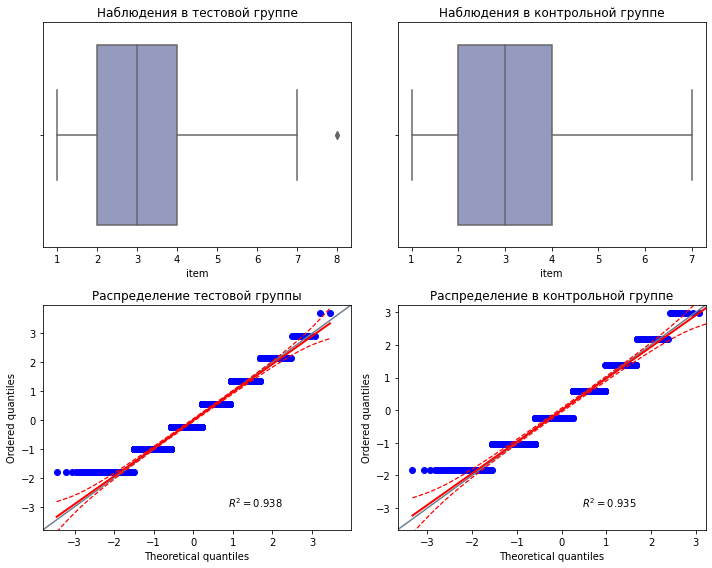

In [24]:
# Применим функцию для визуализации распределений

qqbox(test=prods_test, control=prods_control)

In [25]:
normality(test=prods_test, control=prods_control)

Распределение в обеих группах не принадлежит к нормальному
p_value тестовой группы = 3.119132882505791e-31
p_value контрольной группы = 5.1697472489226224e-26


### Сравним группы между собой
Для сравнения средних будем использовать **t-test**, т.к.<br>
в выборках у нас достаточно большое количество наблюдений, отсутствие значимых<br>
выбросов, а также дисперсии в обеих группах гомогенны.<br> 
Поэтому нормальность распределений не критична<br>

Сформулируем проверяемые гипотезы:<br>
**H0**: Среднее количество товаров в заказе в группах не отличаются между собой;<br>
**H1**: Среднее количество товаров в заказе в группах статистически значимо отличаются

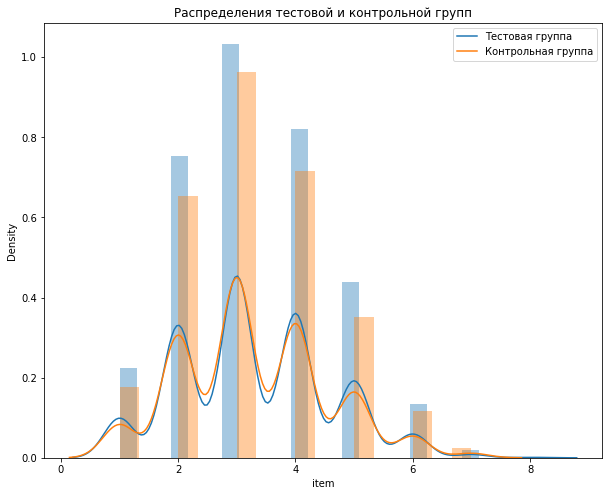

Наблюдений в тестовой группе: 2514
Наблюдений в контрольной группе: 1609
Дисперсии гомогенны
Результаты теста:
Статистика: 0.09831810423573856
p-value: 0.9216844843645677
H0: A==B - Группы не различаются!


In [26]:
# Используем функцию t-test

t_test(test=prods_test, control=prods_control)

In [27]:
# Посмотрим на фактические средние в группах

prods.groupby('group').item.mean()

group
A    3.284236
B    3.284027
Name: item, dtype: float64

Также, применим **bootstrap** средних и посмотрим<br>
совпадут ли результаты.<br>

**H0** - средние значения групп равны<br>
**H1** - средние значения групп не равны

100%|██████████| 10000/10000 [00:21<00:00, 467.60it/s]


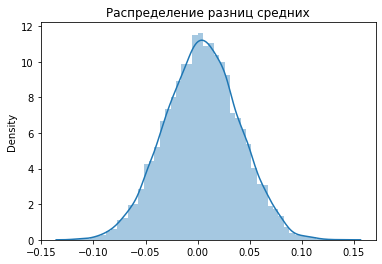

Доверительный интервал: [-0.06563246  0.07319014]


In [28]:
bootstrap(test=prods_test, control=prods_control)

0 принадлежит доверительному интервалу<br>


С помощью метода **bootstrap** мы посчитали разницу средних в наших группах,<br>
построили доверительный интервал и посмотрели входит ли 0 в этот интервал.<br>
Т.к. он входит в него, то средние значения в группах не отличаются между собой<br>

**Вывод**: по результатам тестов, значимых различий по среднему количеству<br>
товаров в заказе между контрольной и тестовой группами нет

## 2. Среднее количество заказов

In [29]:
users_order['group'] = users_order['group'].astype(str).replace({'1': 'A', "0": 'B'})

In [30]:
orders = users_order.groupby(['group', 'user_id'])\
                    .agg({'order_id': 'count'})\
                    .rename(columns={"order_id": 'quantity'})\
                    .reset_index()
orders.head()

,group,user_id,quantity
0,A,965,9
1,A,967,5
2,A,970,2
3,A,971,5
4,A,973,5


In [31]:
orders_test = orders[orders['group'] == 'A']['quantity']
orders_control = orders[orders['group'] == 'B']['quantity']

In [32]:
orders = orders[orders.quantity < orders.quantity.max()]

orders.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99])[["quantity"]].T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
quantity,1016.0,4.252953,2.399506,1.0,1.0,2.0,4.0,6.0,9.0,11.0,15.0


In [33]:
orders.groupby("group").quantity\
     .agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
group,,,,,
A,501,5,5.249501,2.343422,15
B,515,3,3.283495,2.029265,13


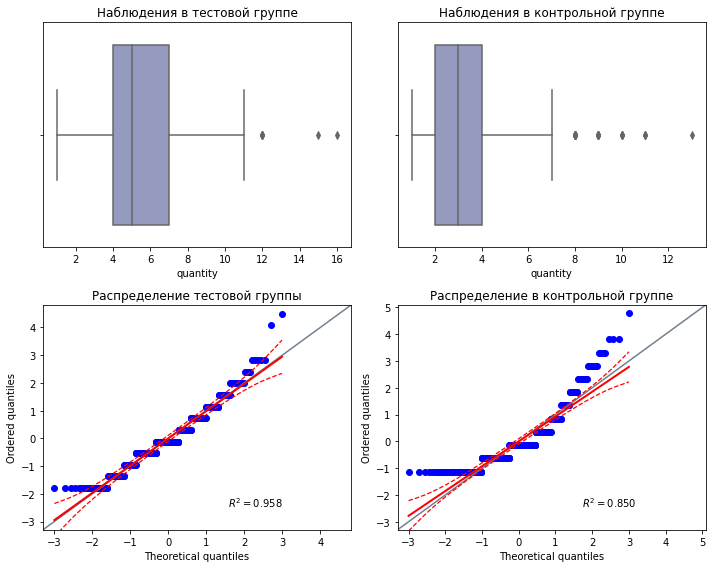

In [34]:
# Применим функцию для визуализации распределений

qqbox(test=orders_test, control=orders_control)

In [35]:
normality(test=orders_test, control=orders_control)

Распределение в обеих группах не принадлежит к нормальному
p_value тестовой группы = 8.639834681023473e-11
p_value контрольной группы = 1.032206798753868e-21


In [36]:
stats.levene(orders_test, orders_control) # гомогенность дисперсий

LeveneResult(statistic=15.214827164983237, pvalue=0.00010226129327774369)

### Сравним группы между собой

Тест Шапиро-Уилка на нормальность распределения показал, что распределения<br>
в тестовой и контрольной группах не принадлежит к нормальному. Кроме того,<br>
требование гомогенности дисперсий также не соблюдено(pvalue < 0.05).<br>

Для сравнения средних будет использован метод **bootstrap**.<br>
**H0** - средние значения групп равны<br>
**H1** - средние значения групп не равны

100%|██████████| 10000/10000 [00:19<00:00, 506.14it/s]


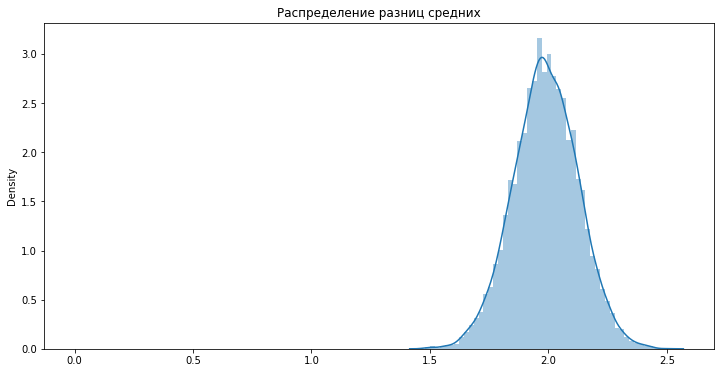

Доверительный интервал: [1.71650485 2.25436893]


In [37]:
bootstrap(test=orders_test, control=orders_control)

In [38]:
orders.groupby('group').quantity.mean().round(2)

group
A    5.25
B    3.28
Name: quantity, dtype: float64

По результатам теста видим, что 0 не включен в доверительный интервал,<br>
а значит, у нас есть все основания полагать, что между двумя группами<br>
есть статистически значимая разница.<br>

**Вывод**: между группами имеется статистически значимое различие<br>
по среднему количеству заказов. 

## 3. Средний чек

In [39]:
average_check = df.groupby(['user_id', 'order_id', 'group'], as_index=False)\
               .agg({'price': 'sum'})\
               .rename(columns={'price': 'revenue'})
average_check.head()

,user_id,order_id,group,revenue
0,964,1255,B,408.7
1,964,1257,B,310.2
2,965,1256,A,250.5
3,965,3946,A,860.6
4,965,9097,A,608.2


In [40]:
average_test = average_check[average_check['group'] == 'A']['revenue']
average_control = average_check[average_check['group'] == 'B']['revenue']

In [41]:
average_check = average_check[average_check.revenue < average_check.revenue.max()]

average_check.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99])[["revenue"]].T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
revenue,4122.0,373.819942,245.581484,1.0,85.0,194.55,313.0,508.625,860.59,1165.158,1668.6


In [42]:
average_check.groupby("group").revenue\
     .agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
group,,,,,
A,2513,306.7,369.039793,245.454749,1641.1
B,1609,326.3,381.285768,245.669506,1668.6


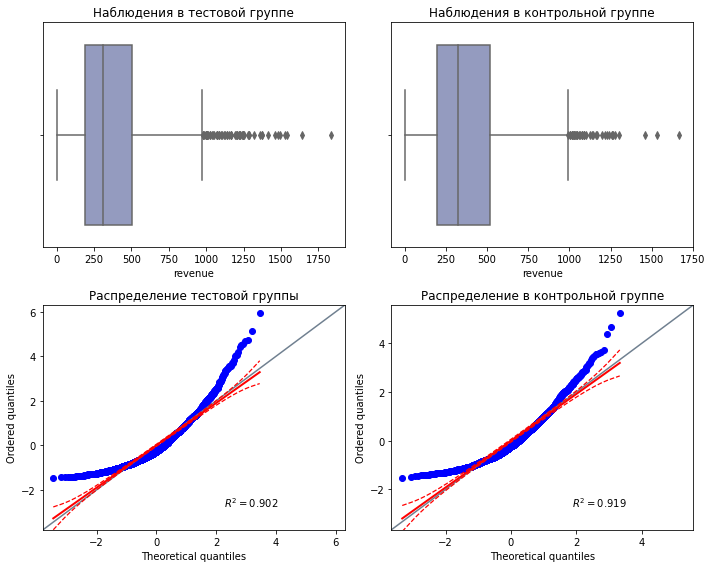

In [43]:
qqbox(test=average_test, control=average_control)

In [44]:
normality(test=average_test, control=average_control)

Распределение в обеих группах не принадлежит к нормальному
p_value тестовой группы = 2.2913337444601104e-37
p_value контрольной группы = 1.347362172388217e-28


In [45]:
stats.levene(average_test, average_control)

LeveneResult(statistic=0.2630999575712736, pvalue=0.6080258899079423)

pvalue: 0.6080258899079423 > 0.05 - требование гомогенности дисперсий выполняется

Для сравнения средних используем **t-test**<br>

Сформулируем проверяемые гипотезы:<br>
**H0**: Средние чеки в группах не отличаются между собой;<br>
**H1**: Средние чеки в группах статистически значимо различаются

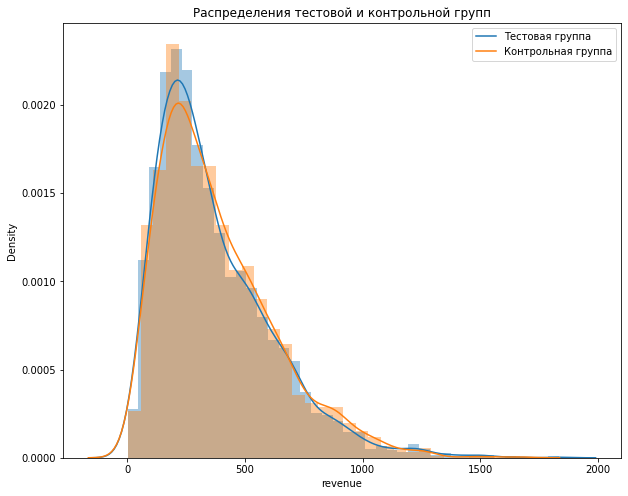

Наблюдений в тестовой группе: 2514
Наблюдений в контрольной группе: 1609
Дисперсии гомогенны
Результаты теста:
Статистика: -1.4815692121713073
p-value: 0.13853141121218765
H0: A==B - Группы не различаются!


In [46]:
t_test(test=average_test, control=average_control)

По результатам теста, мы не можем отклонить нулевую гипотезу.<br>


Применим метод bootstrap к группам и сравним результаты тестов.<br>
**H0** - средние значения групп равны<br>
**H1** - средние значения групп не равны

100%|██████████| 10000/10000 [00:23<00:00, 427.36it/s]


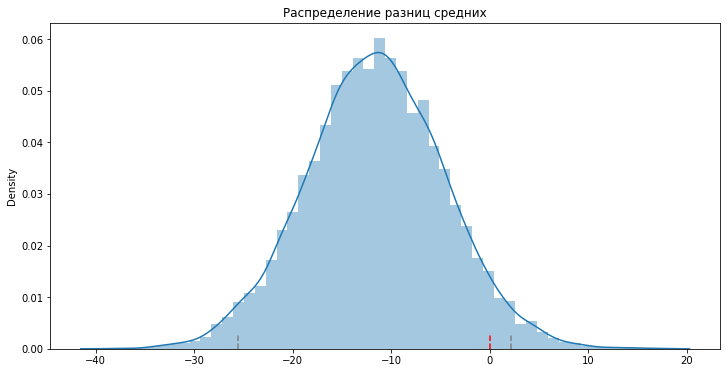

Доверительный интервал: [-25.51354912   2.13660998]


In [47]:
bootstrap(test=average_test, control=average_control)

Т.к. 0 входит в доверительный интервал, то мы не можем отклонить нулевую гипотезу<br>
о равенстве средних в группах.

In [48]:
average_check.groupby('group').revenue.mean() 

group
A    369.039793
B    381.285768
Name: revenue, dtype: float64

## Основные выводы<br>


1. **Среднее количество заказов**: статистически значимая разница в этой метрике показывает,<br>
что в группе с новой системой рекомендаций пользователи совершают больше заказов. Это может говорить о том,<br>
что новая система действительно помогает пользователям эффективнее взаимодействовать с приложением и<br>
находить необходимые товары.<br>
2. **Среднее количество товаров в заказе**: новая система рекомендаций не повлияла на эту метрику,<br>
однако это может быть обусловлено наличием специальных предложений или акций на определенные продукты.<br>
3. **Средний чек**: отсутствие статистически значимой разницы в этой метрике может означать,<br>
что новая система рекомендаций не повлияла на средний чек заказов. Возможно, пользователи<br>
новой системы рекомендаций стали делать больше, но мелких покупок, а возможно, что<br>
рост этой метрики будет заметен на более длительной временной дистанции. Следует проанализировать<br>
какие товары добавляют в заказы, чтобы понять, как можно увеличить средний чек через систему рекомендаций.<br>

Новая система действительно помогает пользователям более эффективно взаимодействовать с приложением.<br>
Если посчитать среднюю выручку с пользователя (которая как раз складывается из среднего чека и среднего<br> числа заказов), то мы увидим явный прирост выручки, что, очевидно, полезно для бизнеса.<br>
 Смогла ли новая система рекомендаций принести пользу пользователям - да, смогла.<br>
 Поэтому я считаю, что **стоит** раскатывать новую систему рекомендаций на всех пользователей.